# A strategy for trading ETH to make more BTC
Ipython notebook for the medium article https://medium.com/coinmonks/a-strategy-for-trading-eth-to-make-more-btc-3985c3c93c04

In [17]:
# Imports
%matplotlib inline
import quandl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import backtesters
reload(backtesters) # make sure changes are reloaded
from backtesters import MABacktester # see code in backtester module

In [62]:
# Get ETH prices for GDAX exchange
eth = quandl.get("GDAX/ETH_BTC") 
eth = eth.shift(1).dropna() # GDAX has daily OPEN, shift to get daily CLOSE
eth.columns = [u'Last', u'High', u'Low', u'Volume'] # rename columns

In [73]:
# Use same time periods and dates as medium article
training_cutoff_date = "2017-05-19" 
training_cutoff_i = eth.index.get_loc(training_cutoff_date)
eth = eth.loc[:'2018-05-13'] # data up to 2018-05-13

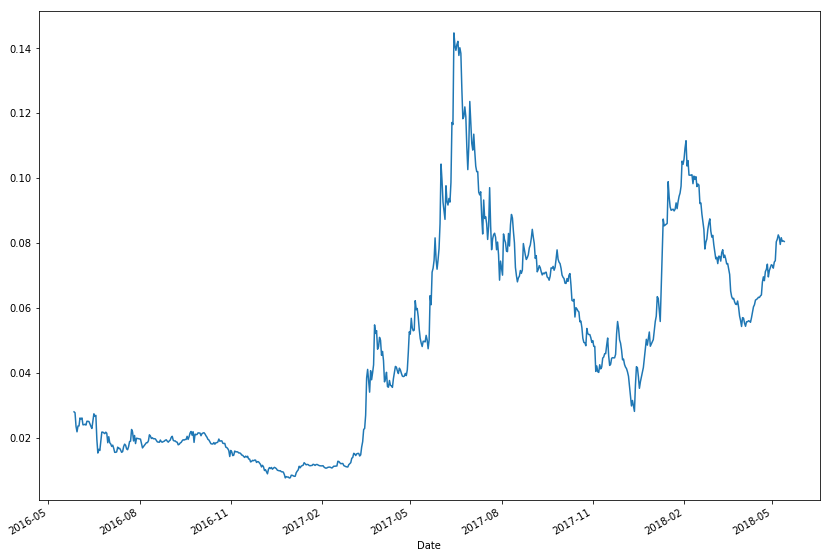

In [74]:
# Chart of ETH price in BTC
eth['Last'].plot(figsize=(14,10))

In [21]:
# We also need BTCUSD prices for some of the return comparisons
btc = quandl.get("BCHAIN/MKPRU") 
btc = btc.shift(-1) # data set has daily open, we want daily close
btc = btc.loc['2010-08-17':].fillna(method = 'ffill') 
btc.columns = ['Last'] # for consistency

In [75]:
# Find optimal MA lookback using training data only
ms_range = [1]
ml_range = np.arange(5,100)
returns = []

for ms in ms_range:
    for ml in ml_range:
        results = MABacktester(eth['Last'].iloc[:training_cutoff_i], ms=ms,ml=ml,ema=False, long_only=False).results() 
        #_ , _, r = bt.backtest_ma(eth['Last'].iloc[:training_cutoff], ms = ms, ml = ml, long_only=False)
        #market, strategy, trades, sharpe = r
        #returns.append((ml,np.round(strategy,1)))
        returns.append((ml,np.round(results['Strategy'],1)))

In [76]:
# Find the top few
returns.sort(key = lambda x: x[1])
returns[::-1][:10]

[(18, 487.2),
 (24, 470.7),
 (17, 425.9),
 (71, 423.6),
 (96, 405.0),
 (74, 404.3),
 (98, 398.7),
 (97, 397.7),
 (72, 397.4),
 (29, 391.3)]

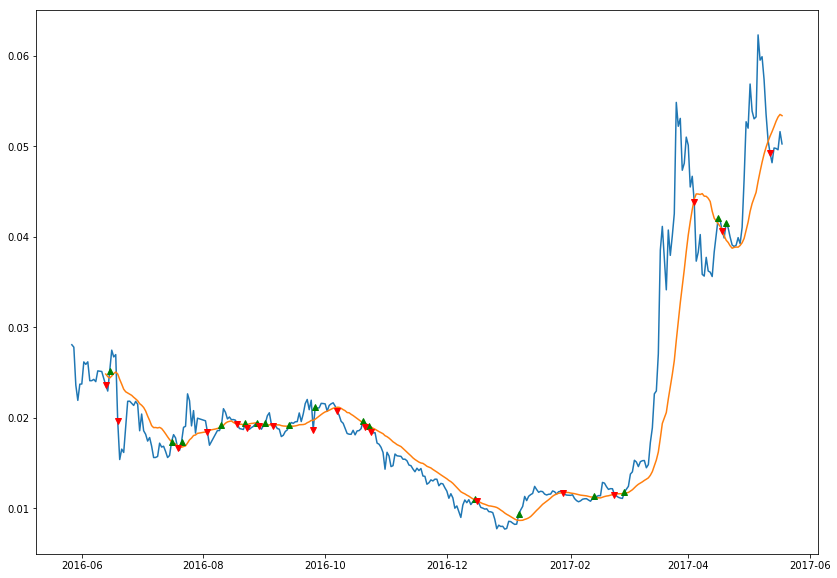

In [26]:
# Visualise on chart, arrows show buys and sells
train = MABacktester(eth['Last'].iloc[:training_cutoff_i], ms=1,ml=18,ema=False, long_only=False)
train.plot(figsize = (14,10))

In [77]:
# Training period
print train
train.results()

MA Backtest Strategy (ms=1, ml=18, ema=False, long_only=False, start=2016-05-27, end=2017-05-18)


{'Market': 79.12,
 'Market_pa': 81.85,
 'Sharpe': 1.54,
 'Strategy': 487.19,
 'Strategy_pa': 514.83,
 'Trades': 36,
 'Years': 0.97}

In [78]:
# Test period
test = MABacktester(eth['Last'].iloc[training_cutoff_i:], ms=1,ml=18,ema=False, long_only=False)
test.results()

{'Market': 69.56,
 'Market_pa': 71.12,
 'Sharpe': 2.03,
 'Strategy': 627.42,
 'Strategy_pa': 652.99,
 'Trades': 24,
 'Years': 0.98}

In [79]:
# Full period
full = MABacktester(eth['Last'], ms=1,ml=18,ema=False, long_only=False)
full.results()

{'Market': 187.03,
 'Market_pa': 71.24,
 'Sharpe': 2.45,
 'Strategy': 4500.24,
 'Strategy_pa': 605.06,
 'Trades': 59,
 'Years': 1.96}

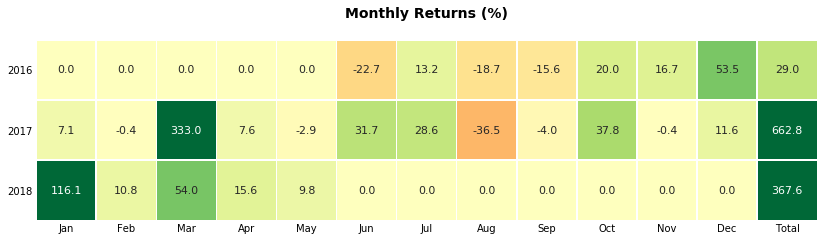

In [32]:
full.plot_heatmap(target="strategy", figsize=(14,10))

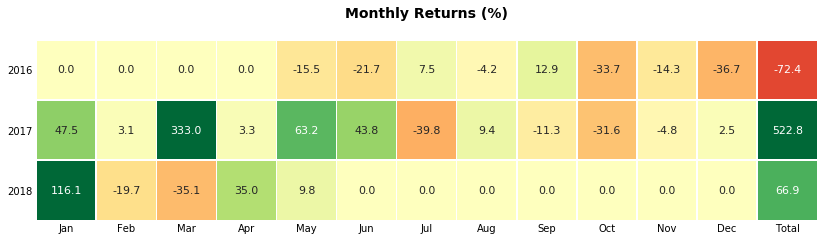

In [33]:
full.plot_heatmap(target="market", figsize=(14,10))

In [80]:
# strategy drawdowns
full.drawdowns(target='strategy',cutoff=20)

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,51.03,12.49385,6.11838,2017-07-18,2017-09-05,49 days,2017-12-10,96 days
1,45.61,1.02921,0.55975,2016-06-14,2016-10-24,132 days,2016-12-05,42 days
2,42.22,14.71885,8.50519,2017-12-13,2017-12-22,9 days,2018-01-10,19 days
3,41.70,7.58139,4.42017,2017-05-06,2017-05-22,16 days,2017-06-12,21 days
4,26.11,6.40854,4.73548,2017-03-26,2017-04-24,29 days,2017-04-30,6 days
5,23.41,10.89296,8.34273,2017-11-07,2017-11-20,13 days,2017-12-10,20 days
6,21.76,10.48143,8.20026,2017-06-14,2017-06-30,16 days,2017-07-09,9 days


In [81]:
# market drawdowns
full.drawdowns(target='market',cutoff=20)

,dd,high,low,highd,lowd,days,recoveryd,rdays
0,80.52,0.14479,0.02820,2017-06-14,2017-12-13,182 days,2018-05-13,151 days
1,72.63,0.02806,0.00768,2016-05-27,2016-12-30,217 days,2017-03-18,78 days
2,51.28,0.11158,0.05436,2018-02-03,2018-03-31,56 days,2018-05-13,43 days
3,35.10,0.05485,0.03560,2017-03-26,2017-04-13,18 days,2017-05-02,19 days
4,23.77,0.06231,0.04750,2017-05-06,2017-05-19,13 days,2017-05-21,2 days


In [82]:
# Comparison of all returns over the test period

start_i = training_cutoff_i
end_i = -1
start_date = eth.iloc[start_i].name
end_date = eth.iloc[end_i].name
ETHBTC_end = eth['Last'].iloc[end_i]
ETHBTC_start = eth['Last'].iloc[start_i]
BTCUSD_end = btc['Last'].loc[end_date]
BTCUSD_start = btc['Last'].loc[start_date]
BTC_strategy_at_end = test.results()['Strategy'] / 100 + 1
BTC_market_at_end  = test.results()['Market'] / 100 + 1

print "Start %s End %s" % (start_date, end_date)
print "-" * 35
print "Return of HODL ETH in USD %.2f%%" % ( ( (ETHBTC_end * BTCUSD_end) / (ETHBTC_start * BTCUSD_start) - 1) *100)
print "Return of HODL BTC in USD %.2f%%" % ((BTCUSD_end / BTCUSD_start - 1) *100)
print "Return of strategy in USD %.2f%%" % ((BTC_strategy_at_end * BTCUSD_end / BTCUSD_start - 1) *100)
print "-" * 35
print "Return of HODL eth in BTC %.2f%%" % ((ETHBTC_end / ETHBTC_start - 1) *100)
print "Cross check %.2f%%" % ((BTC_market_at_end * BTCUSD_end / BTCUSD_start - 1) *100)

Start 2017-05-19 00:00:00 End 2018-05-13 00:00:00
-----------------------------------
Return of HODL ETH in USD 654.44%
Return of HODL BTC in USD 344.94%
Return of strategy in USD 3136.61%
-----------------------------------
Return of HODL eth in BTC 69.56%
Cross check 654.45%


In [83]:
# Statistical significance
# null hypothesis is that strategy is no different from buy and hold
# calculate prob of buy and hold achieving the same or better result
# try this using a distibution with the same moments
sims = 5000
np.random.RandomState(seed=0)
test_stat =  train.results()['Strategy']
end = []
for i in np.arange(sims):
    simulated = np.random.choice(train.market_ret().dropna(),training_cutoff_i,replace = True)
    end.append((np.exp(simulated.cumsum())[-1] - 1) * 100)

In [84]:
count = 0.0
for i in end:
    if i >= test_stat:
        count += 1
print "p value %.1f%%" % (count / len(end) * 100)

p value 15.6%


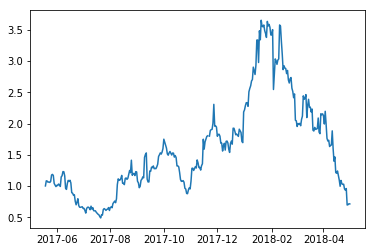

In [85]:
np.random.RandomState(seed=0)
dates = pd.date_range(start_date, periods = training_cutoff_i)
simulated = pd.Series(np.random.choice(train.market_ret(),training_cutoff_i,replace = True), index= dates)
simprices = simulated.cumsum().apply(np.exp)
plt.plot(simprices)

In [86]:
# Statistical significance
# null hypothesis is that strategy does not capture the autcorrelations so would just do as well on a similar shaped distn
# calculate prob of strategy applied to simulated results achieving the same or better return
np.random.RandomState(seed=0)
test_stat = train.results()['Strategy']
end = []
dates = pd.date_range(start_date, periods = training_cutoff_i)
for i in np.arange(sims):
    simulated = pd.Series(np.random.choice(train.market_ret(),training_cutoff_i,replace = True), index= dates)
    simprices = simulated.cumsum().apply(np.exp)
    simbacktest = MABacktester(simprices, ms = 1, ml = 18, long_only = False)
    end.append(simbacktest.results()['Strategy'])

In [87]:
count = 0.0
for i in end:
    if i >= test_stat:
        count += 1
print "p value %.1f%%" % (count / len(end) * 100)
# 5.3% chance that our strategy got such a good result by chance

p value 6.8%


In [88]:
# Statistical significance
# Choose the same number of longs and shorts but randomise where they occur
# What is the prob of this doing as well as the strategy did
np.random.RandomState(seed=0)
test_stat = train.results()['Strategy']
end = []
market = train.market_ret()
stance = train.stance()
for i in np.arange(sims):
    new_stance = pd.Series(np.random.choice(stance, size = len(stance), replace = False), index = stance.index)
    strategy = market * new_stance.shift(1) 
    ret = ((np.exp(strategy.cumsum()[-1]) - 1) * 100)
    end.append(ret)

In [89]:
count = 0.0
for i in end:
    if i >= test_stat:
        count += 1
print "p value %.1f%%" % (count / len(end) * 100)

p value 4.9%
